In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
from scipy import signal, stats
from hottbox.algorithms.decomposition.fusion import CMTF

import tensorly as tl

concentrations = pd.read_table("../Acar_data/concentrations.txt", sep="\s+")
mat = sio.loadmat("../Acar_data/EEM_NMR_LCMS.mat")

# Data description

# Mixture concentrations

In [ ]:
print(concentrations.shape)
print((concentrations != 0).sum(axis=1).describe())

## Fluorescence Spectroscopy (Excitation Emission Matrix - EEM)

- 28 mixtures
- emission wavelength (mode 2)
- excitation wavelength (mode 3)

In [88]:
eem = mat["X"][0][0]["data"]

print(eem.shape)

(28, 251, 21)


## NMR spectra
- 28 mixtures
- chemical shifts (mode 2)
- gradient levels (mode 3)

In [4]:
nmr = mat["Y"][0][0]["data"]
print(nmr.shape)

(28, 13324, 8)


## LC-MS

Matrix n_mixtures x n_features

In [108]:
lcms = mat["Z"][0][0]["data"]

print(lcms.shape)

(28, 168)


# Tensor decomposition

In [32]:
ranks = range(1, 6)
errors = []
for rank in ranks:
    fac = tl.decomposition.parafac(nmr, rank=rank)
    err = tl.norm(tl.cp_to_tensor(fac) - nmr)
    errors.append(err)
errors = np.array(errors)

In [7]:
tl.cp_normalize(fac).shape

(28, 13324, 8)

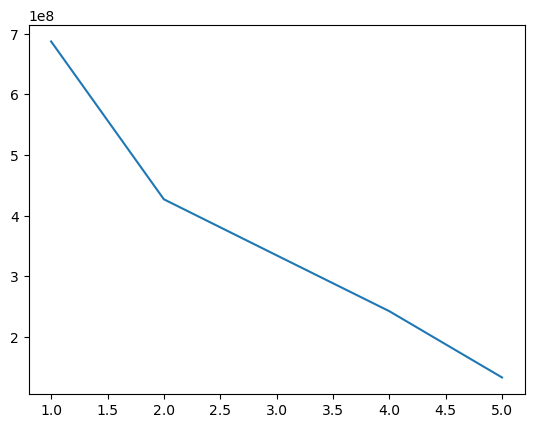

In [33]:
plt.plot(ranks, errors)

In [80]:
rank = 5
fac = tl.decomposition.non_negative_parafac(nmr, rank=rank)

In [82]:
fac = tl.cp_normalize(fac)

(28, 5)


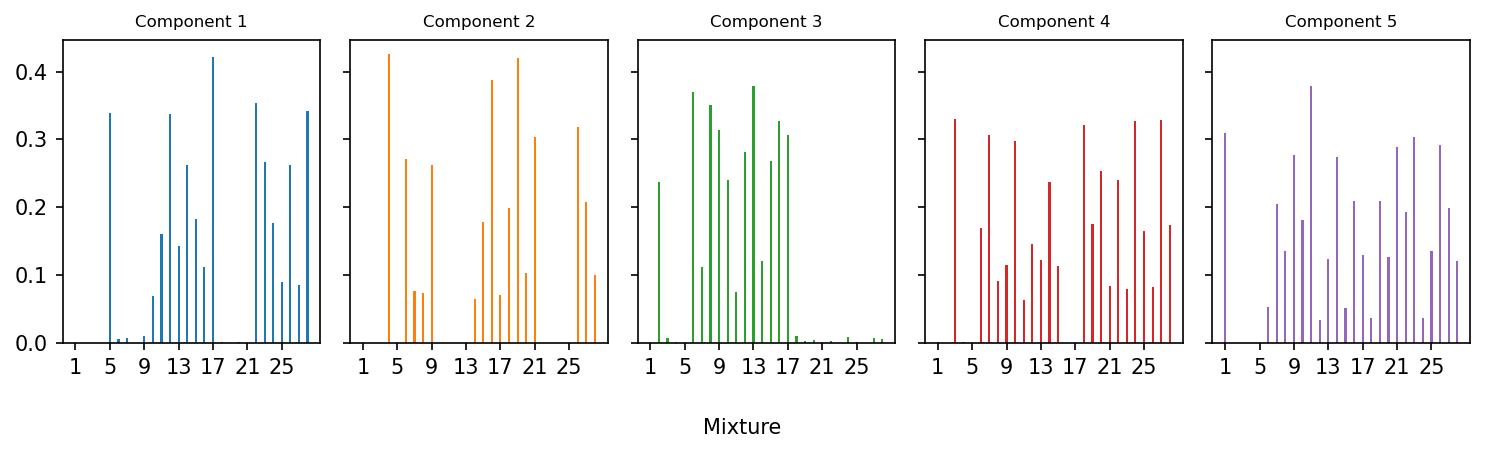

In [106]:
f, ax = plt.subplots(1, rank, figsize=(10, 3), sharex=True, sharey=True, dpi=150)

components = [1, 2, 3]
width = 0.25

lig_facs = fac[1][0]
print(lig_facs.shape)
x_lig = np.arange(28)

for i in range(rank):
    ax[i].bar(x_lig, lig_facs[:, i], width, label="Component 1", color=f"C{i}")
    ax[i].set_title(f"Component {i + 1}", fontsize=8)
ax[0].set_xticks(x_lig[::4], (x_lig + 1)[::4])
f.supxlabel("Mixture", fontsize=10)
f.tight_layout()
f.savefig("figures/parafac_nmr_spectra_cp_factors_per_mixture.pdf", dpi=300)
plt.show()

In [84]:
from scipy.stats import spearmanr

col_names = concentrations.columns
for cp_idx in range(5):
    print(f"Component {cp_idx + 1}")
    for col_idx in range(5):
        cor_res = spearmanr(lig_facs[:, cp_idx], concentrations.iloc[:, col_idx])
        if np.abs(cor_res.statistic) > 0.5:
            print(f"{col_names[col_idx]}\t", cor_res)

Component 1
Propanol	 SignificanceResult(statistic=0.9552092650361735, pvalue=2.8817844723874596e-15)
Component 2
Malto	 SignificanceResult(statistic=0.952483574109862, pvalue=6.115796232408e-15)
Component 3
Trp-Gly	 SignificanceResult(statistic=0.8935844618051503, pvalue=1.552649102529658e-10)
Component 4
Phe	 SignificanceResult(statistic=0.9579524854000545, pvalue=1.2870795266589864e-15)
Component 5
Val-Tyr-Val	 SignificanceResult(statistic=0.9813532428193826, pvalue=3.768841797526262e-20)


In [104]:
mask = np.isnan(eem)
eem[mask] = 0
fac_eem = tl.decomposition.non_negative_parafac(eem, rank=rank, init="svd")
fac_eem = tl.cp_normalize(fac_eem)

In [105]:
from scipy.stats import spearmanr

lig_facs = fac_eem[1][0]

col_names = concentrations.columns
for cp_idx in range(5):
    print(f"Component {cp_idx + 1}")
    for col_idx in range(5):
        cor_res = spearmanr(lig_facs[:, cp_idx], concentrations.iloc[:, col_idx])
        if np.abs(cor_res.statistic) > 0.5:
            print(f"{col_names[col_idx]}\t", cor_res)

Component 1
Val-Tyr-Val	 SignificanceResult(statistic=0.9813532428193826, pvalue=3.768841797526262e-20)
Component 2
Phe	 SignificanceResult(statistic=0.9759000729485333, pvalue=1.0262424147542531e-18)
Component 3
Trp-Gly	 SignificanceResult(statistic=0.9151166175112985, pvalue=9.312591943635472e-12)
Component 4
Trp-Gly	 SignificanceResult(statistic=0.9151166175112985, pvalue=9.312591943635472e-12)
Component 5
Trp-Gly	 SignificanceResult(statistic=0.8568003624738137, pvalue=5.93105905060349e-09)


In [130]:
from hottbox.algorithms.decomposition.fusion import CMTF
from hottbox.core import Tensor

cmtf = CMTF(verbose=True)

tensor = Tensor(nmr)
tensor2 = Tensor(lcms)
out = cmtf.decompose(tensor, [tensor2], rank=(5, ))

TypeError: reduce() of empty iterable with no initial value

In [120]:
tensor

This tensor is of order 3 and consists of 2984576 elements.
Sizes and names of its modes are (28, 13324, 8) and ['mode-0', 'mode-1', 'mode-2'] respectively.

In [123]:
tensor2

This tensor is of order 2 and consists of 4704 elements.
Sizes and names of its modes are (28, 168) and ['mode-0', 'mode-1'] respectively.